# Classification

Import libraries and helpers

In [1]:
import os, sys

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from classifier import Classifier
from env_variables import *
from dataset.loading import DataLoader

import numpy as np
import random
import warnings
from matplotlib import pyplot as plt

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

#### Data
Collect the complete TIMIT training dataset. The data are pre-processed into 10 steps long 14-mffc signals with 39 phoneme labels/classes.

In [2]:
data_path = '../../../'
cache_dir = '../../cache/'
dl = DataLoader(data_path, cache_dir)

dr = []
speakers = []
long_version = False
n_mels = 13
delta = False
delta_delta = False
subsamples = 10

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+path_option
if len(speakers):
    path_option = str(len(speakers))+path_option

features, labels, _ = dl.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


Regroup data and label arrays into a phoneme-keyed dictionary.

In [3]:
from dataset.data_processing import *

phonemes, features_train, labels_train, features_test, labels_test = filter_and_downsample(features, labels, percent_limit=.8)

Filtered to 141648 train and 35432 test samples.
...of shape: (10, 13)


### Classification
Largely following the method presented by Jaeger (2014).
The ESN parameters were chosen by hand.

#### 1. Train & Develop

In [4]:
clas = Classifier(W_in_scale=1.0,
                 b_scale=.6,
                 spectral_radius=2.3,
                 weights=.1)

_ = clas.fit(features_train, labels_train, **{
    "n_mels": n_mels,
    "XorZ": "X",
    "N": 100,
    "cache": False
})

In [5]:
print(f'Development Accuracy of x : {clas.score(features_test, labels_test)}')

Development Accuracy of x : 0.5566154888236622


#### 2. Retrain & Evaluate on Whole Dataset
Train

In [6]:
_ = clas.fit(features, labels, **{
    "n_mels": n_mels,
    "XorZ": "X",
    "N": 100,
    "cache": False
})

Test

In [7]:
features_test, labels_test, _ = dl.collectFeaturesInSegments(
    ft='Test',n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=[],dr=dr,sentence=[],
    subsamples=subsamples,path_option=path_option+"_test")

print(f'Training Accuracy of x : {clas.score(features, labels)}')
print(f'Test Accuracy of x     : {clas.score(features_test, labels_test)}')

-from output
---- success
Training Accuracy of x : 0.5381804833973345
Test Accuracy of x     : 0.5383584067347416


Construct a Confusion Matrix to distinguish between classes

In [8]:
labels_pred = clas.predict(features_test)

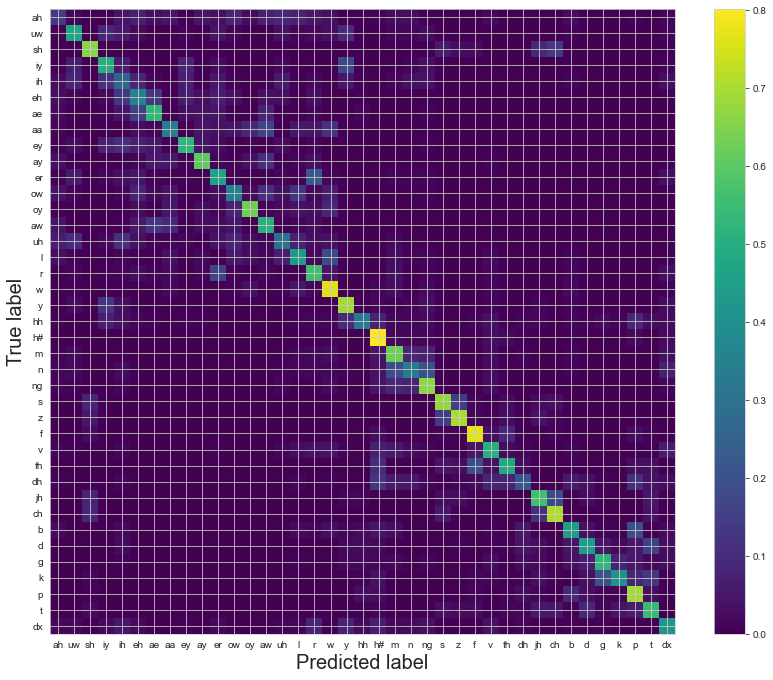

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

phonemes_in_order = ['ah', 'uw', 'sh', 'iy', 'ih', 'eh', 'ae', 'aa', 'ey', 'ay', 'er', 'ow', 'oy', 'aw', 'uh',
               'l', 'r', 'w', 'y', 'hh', 'h#',
               'm', 'n', 'ng',
               's', 'z', 'f', 'v', 'th', 'dh',
               'jh', 'ch',
               'b', 'd', 'g', 'k', 'p', 't', 'dx']


cm = confusion_matrix(labels_test, labels_pred, labels=phonemes_in_order, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=phonemes_in_order)
fig, ax = plt.subplots(figsize=(14,11.5))
ax.set_xlabel("", fontsize = default_font_size)
ax.set_ylabel("", fontsize = default_font_size)
disp.plot(ax=ax, include_values=False)

## Extras

#### Z-Classification: Including the input signals into the conceptors

In [10]:
clas2 = Classifier(1.5, .2, 1.5, .1) # Z optimal params

clas2.fit(features_train, labels_train, **{
    "n_mels":n_mels,
    "XorZ":"Z",
    "N":40,
    "cache":True
})

print(f'Training Accuracy of z : {clas2.score(features_train, labels_train)}')
print(f'Test Accuracy of z     : {clas2.score(features_test, labels_test)}')

Training Accuracy of z : 0.6061786964870666
Test Accuracy of z     : 0.46064385376880507


#### Bayesian Hyperparameter Tuning
Running this is only feasible with small ESNs (<40 neurons).

In [11]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

X_train, X_test, y_train, y_test = train_test_split(features_train,
                                                    labels_train,
                                                    stratify = labels_train,
                                                    random_state = 1)

# Bayesian Optimization wrapper
def objective_function(W_in_scale,
                       b_scale,
                       spectral_radius,
                       weights):

    model = Classifier(W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights)
    model.fit(X_train, y_train, **{
        "n_mels": n_mels,
        "XorZ": "X",
        "N": 100
    })
    return model.score(X_test, y_test)


parameters = {
    'W_in_scale': [.01, 2],
    'spectral_radius': [0.01, 4],
    'b_scale': [0, 2],
    'weights': [.01,1]
}

# Bayesian optimization of the objective function.
optimizer = BayesianOptimization(f = objective_function,
                                 pbounds = parameters,
                                 random_state = 0)
optimizer.maximize(init_points = 10, n_iter = 100)

best_params = optimizer.max['params']
print(f"Best parmaters: {best_params}; f(x) = {optimizer.max['target']}.")


# Scikitlearn
#opt = Classifier()
#opt = BayesSearchCV(Classifier(), parameters, n_iter=50, cv=3)
#opt.fit(features, labels, **{
#   "in_dim":n_mels,
#   "out_dim":n_mels
#})
#print(opt.score(fv, lv))
#print(opt.best_params_)

|   iter    |  target   | W_in_s... |  b_scale  | spectr... |  weights  |
-------------------------------------------------------------------------


KeyError: 'cache'

Plot the tuning progress

In [ ]:
plt.rcParams['text.usetex'] = True
_, ax1 = plt.subplots(figsize = (15, 5))

ax2 = ax1.twinx()

# Scores:
ax1.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, color='r', label="Accuracy - $f(\\rho$, $k_{W^in}$, $k_b$, $r$)")

# Parameters
W_in_scale = []
b_scale = []
spectral_radius = []
weights = []

for res in optimizer.res:
    W_in_scale.append(res["params"]["W_in_scale"])
    b_scale.append(res["params"]["b_scale"])
    spectral_radius.append(res["params"]["spectral_radius"])
    weights.append(res["params"]["weights"])

if True:
    ax1.plot(range(1, 1 + len(optimizer.space.target)), W_in_scale, "--", label="$W^{in}$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), b_scale, "--", label="$k_b$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), spectral_radius, "--", label="$r$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), weights, "--", label="$\\rho$")

ax1.set_xlabel('Iteration', fontsize = 20)
ax1.set_ylabel('Accuracy', color="r", fontsize = 20)
ax2.set_ylabel('Hyperparameter value', fontsize = 20)

ax1.legend(loc="upper left", fontsize = 20)
fig.show()